In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

In [13]:
spotify = pd.read_csv('course_data/spotify.csv')
spotify.head(3)

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616


In [14]:
X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

In [15]:
features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']

features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),)

In [16]:
# We'll do a "grouped" split to keep all of an artist's songs in one split or the other. This is to help prevent signal leakage.

def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


Minimum Validation Loss: 0.1958


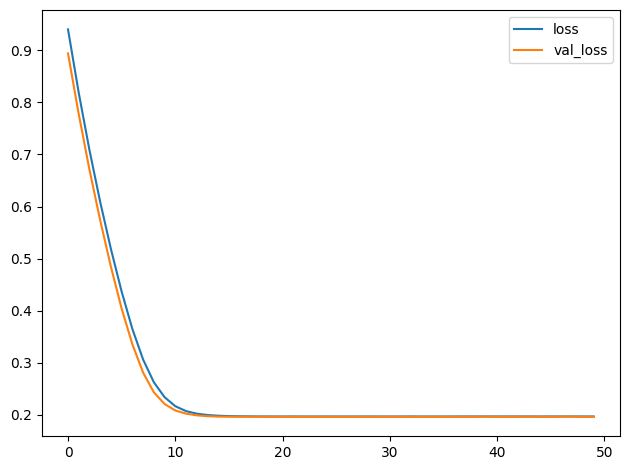

In [17]:
# 1 layer Model

model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),])

model.compile(
    optimizer='adam',
    loss='mae',)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0,)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

Minimum Validation Loss: 0.1958


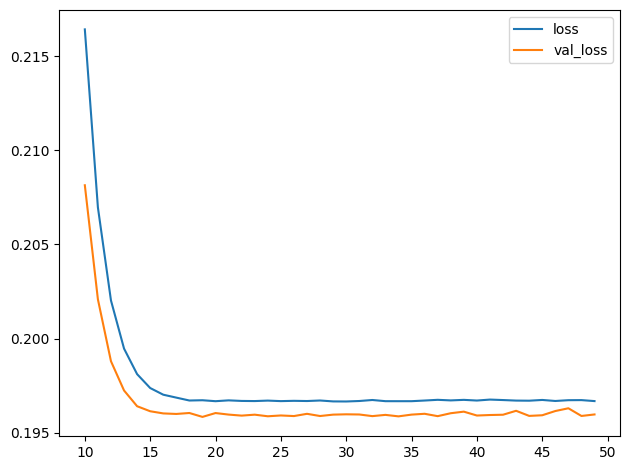

In [18]:
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

The gap between these curves is quite small and the validation loss never increases, so it's more likely that the network is underfitting than overfitting. It would be worth experimenting with more capacity to see if that's the case.

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3056 - val_loss: 0.2116
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2066 - val_loss: 0.2021
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1983 - val_loss: 0.2002
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1945 - val_loss: 0.1981
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1909 - val_loss: 0.1988
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1883 - val_loss: 0.1989
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1902 - val_loss: 0.1979
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1889 - val_loss: 0.1974
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1875 - val_loss: 0.1958
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1846 - val_loss: 0.1957
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1839 - val_loss: 0.1956
Epoch 12/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1827 - val_lo

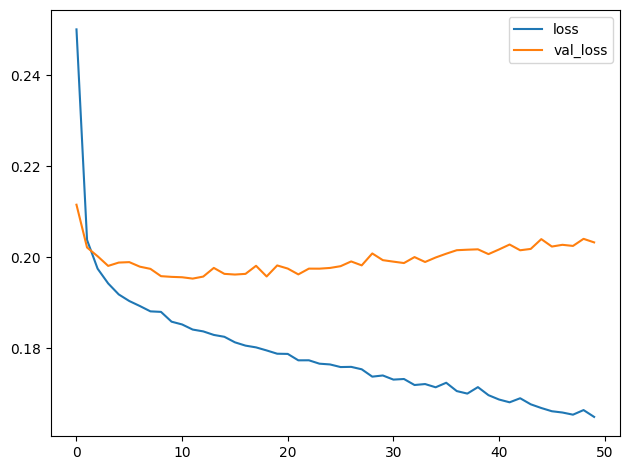

In [19]:
# 3 layers Model

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)])

model.compile(
    optimizer='adam',
    loss='mae',)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

Now the validation loss begins to rise very early, while the training loss continues to decrease. This indicates that the network has begun to overfit. At this point, we would need to try something to prevent it, either by reducing the number of units or through a method like early stopping.

In [20]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2971 - val_loss: 0.2088
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2060 - val_loss: 0.2009
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1962 - val_loss: 0.1982
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1942 - val_loss: 0.1985
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1928 - val_loss: 0.1977
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1909 - val_loss: 0.1962
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1884 - val_loss: 0.1953
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1865 - val_loss: 0.1969
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1862 - val_loss: 0.1956
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1847 - val_loss: 0.1961
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1851 - val_loss: 0.1958
Minimum Validation Loss: 0.1953


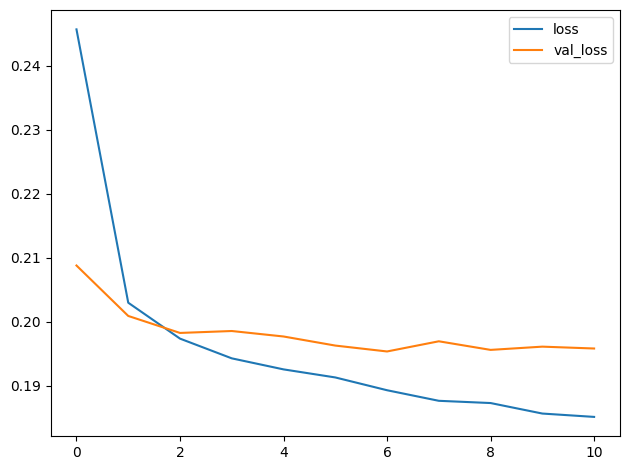

In [21]:
# Model with Early Stopping

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)])

model.compile(
    optimizer='adam',
    loss='mae',)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping])

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

The early stopping callback did stop the training once the network began overfitting. Moreover, by including restore_best_weights we still get to keep the model where validation loss was lowest.